In [16]:
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
import sklearn
%matplotlib inline
print('Libraries loaded')

Libraries loaded


# Load Dataset

In [17]:
print (sklearn.__version__)

0.18.1


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print()
print("Training dataset:")
print(train.head())
print()
print("*******************")
print()
print("Test dataset:")
print(test.head())


Training dataset:
           ID  Count
0  2011100100    135
1  2011100101     96
2  2011100102    111
3  2011100103    102
4  2011100104     54

*******************

Test dataset:
           ID  Count
0  2013040100    NaN
1  2013040101    NaN
2  2013040102    NaN
3  2013040103    NaN
4  2013040104    NaN


# Data Preprocessing

### convert ID column to date format

In [4]:
train['ID'] = train['ID'].astype(str)
train['ID'] = train['ID'].apply(lambda x: x[:4]+' '+x[4:6]+' '+x[6:8]+' '+x[8:])
train['ID'] = train['ID'].apply(lambda x: datetime.strptime(x, '%Y %m %d %H'))

ID = test['ID']
test['ID'] = test['ID'].astype(str)
test['ID'] = test['ID'].apply(lambda x: x[:4]+' '+x[4:6]+' '+x[6:8]+' '+x[8:])
test['ID'] = test['ID'].apply(lambda x: datetime.strptime(x, '%Y %m %d %H'))

### make features from date

In [5]:
train['day'] = train['ID'].dt.weekday
train['hour'] = train['ID'].dt.hour
train['month'] = train['ID'].dt.month
train["DayCount"] = train["ID"].apply(lambda x: x.toordinal()/730000) # Scale daycount

test['day'] = test['ID'].dt.weekday
test['hour'] = test['ID'].dt.hour
test['month'] = test['ID'].dt.month
test["DayCount"] = test["ID"].apply(lambda x: x.toordinal()/730000)

# Visualization

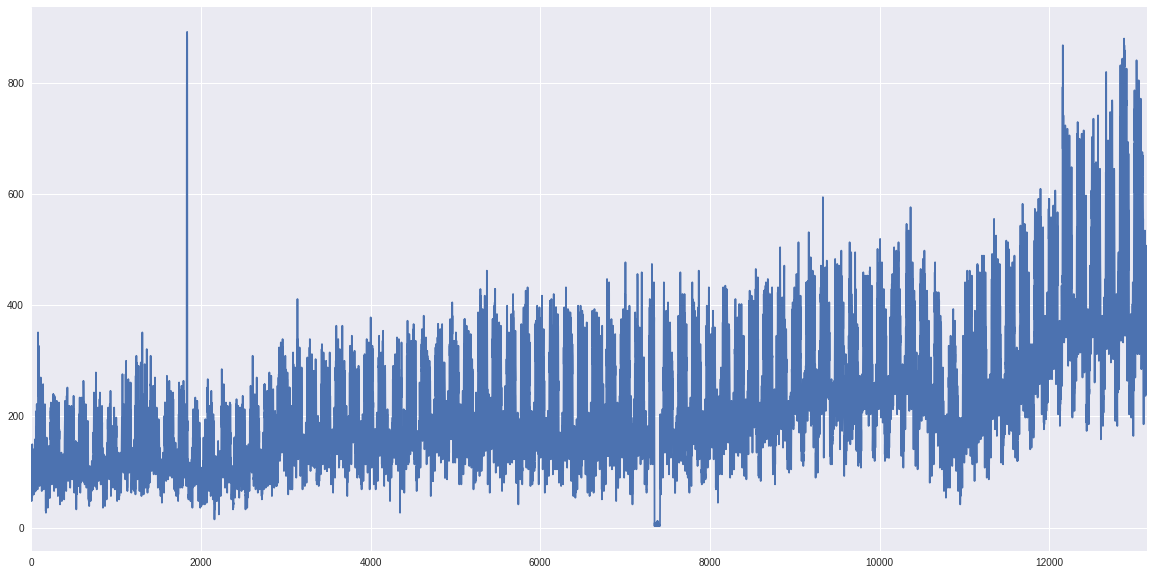

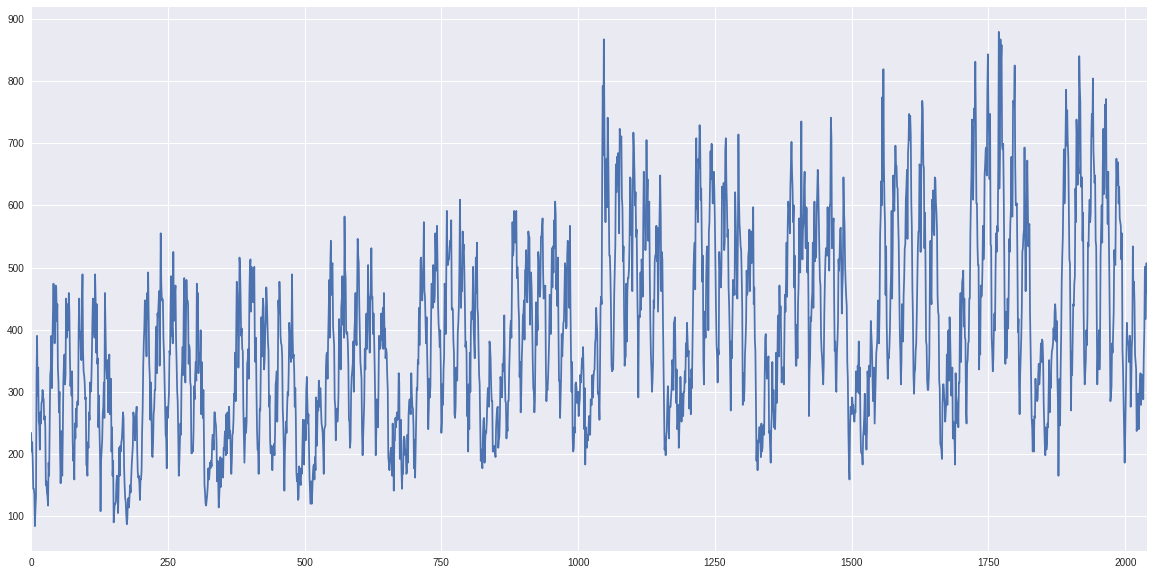

In [6]:
plt.figure(figsize=(20,10))
ax = sns.tsplot(data=train['Count'])

plt.figure(figsize=(20,10))
ax = sns.tsplot(data=train['Count'][11111:])

### From the above and below plots we can see that the time series have a pattern of 7 days and time series increasing from Jan 2013(reason is new year). There is a loss in time series just after new year the time series count is increasing so if we take the data just after the new year we can make a robust and accurate model from the data.

In [7]:
# Take training data after the new year
data = train[11111:].drop('ID',axis=1)
data.head()

,Count,day,hour,month,DayCount
11111,234,5,23,1,1.006675
11112,204,6,0,1,1.006677
11113,219,6,1,1,1.006677
11114,189,6,2,1,1.006677
11115,144,6,3,1,1.006677


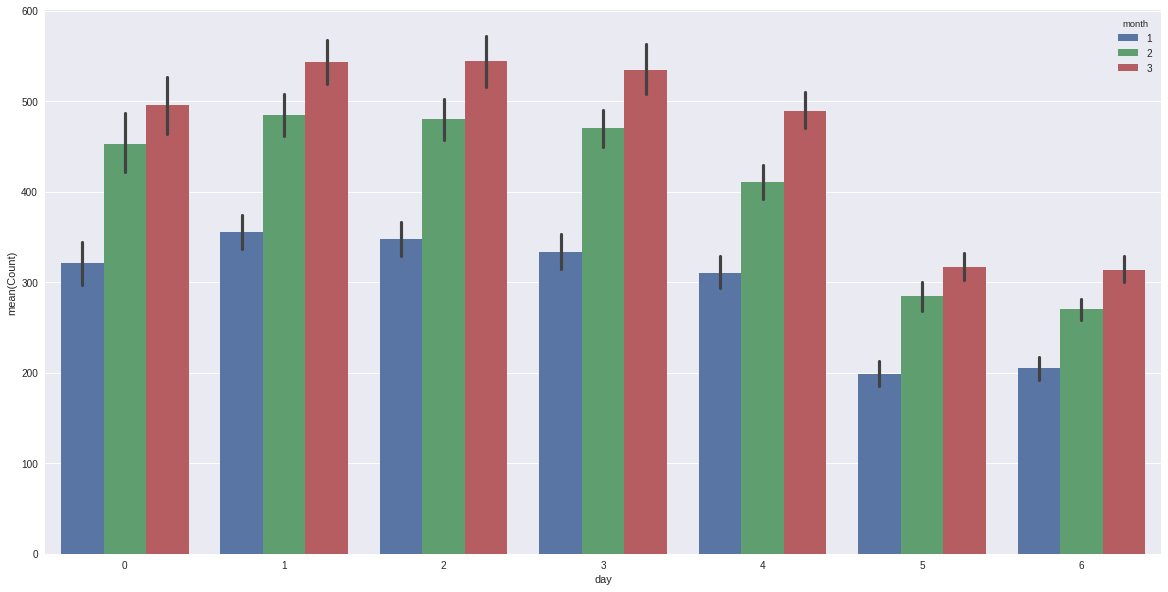

In [8]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="day", y="Count", hue='month', data=data)

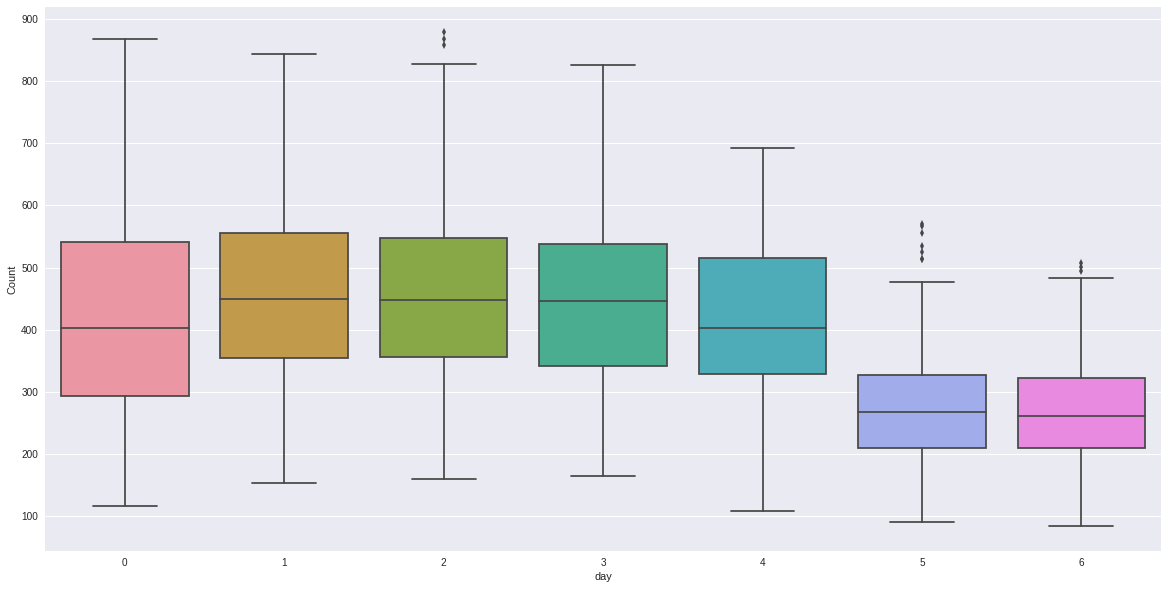

In [9]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="day", y="Count", data=data)

### Here we can see that day 5 and 6 have minimum count. The count increase from day 0 and than the count is almost steady for day 1,2,3,4 and than dearease on day 5 and 6

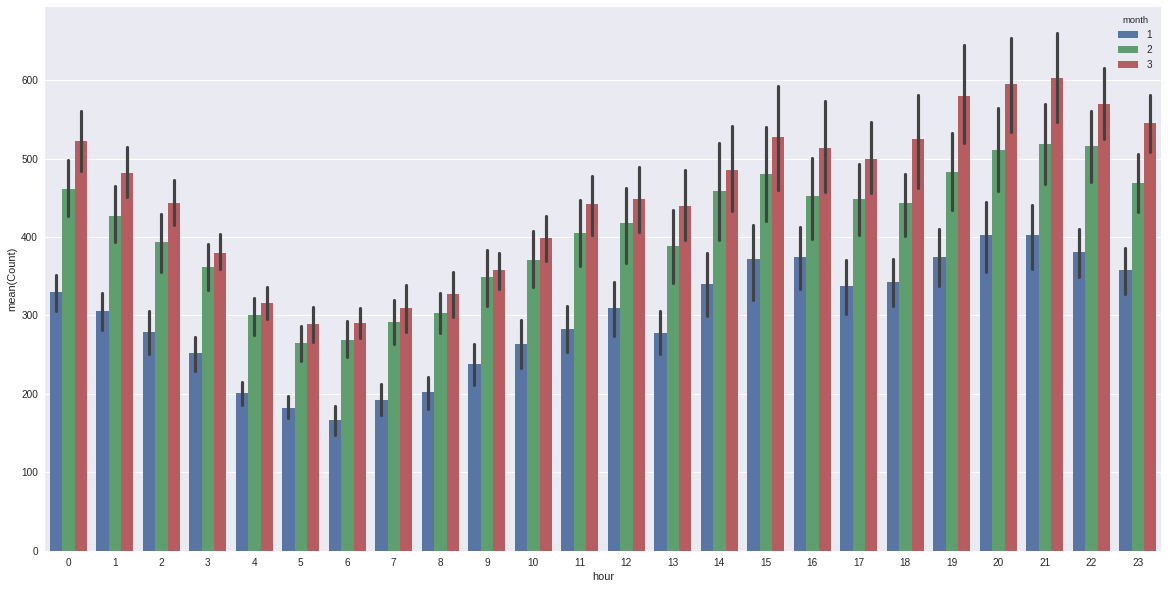

In [10]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x="hour", y="Count", hue='month', data=data)

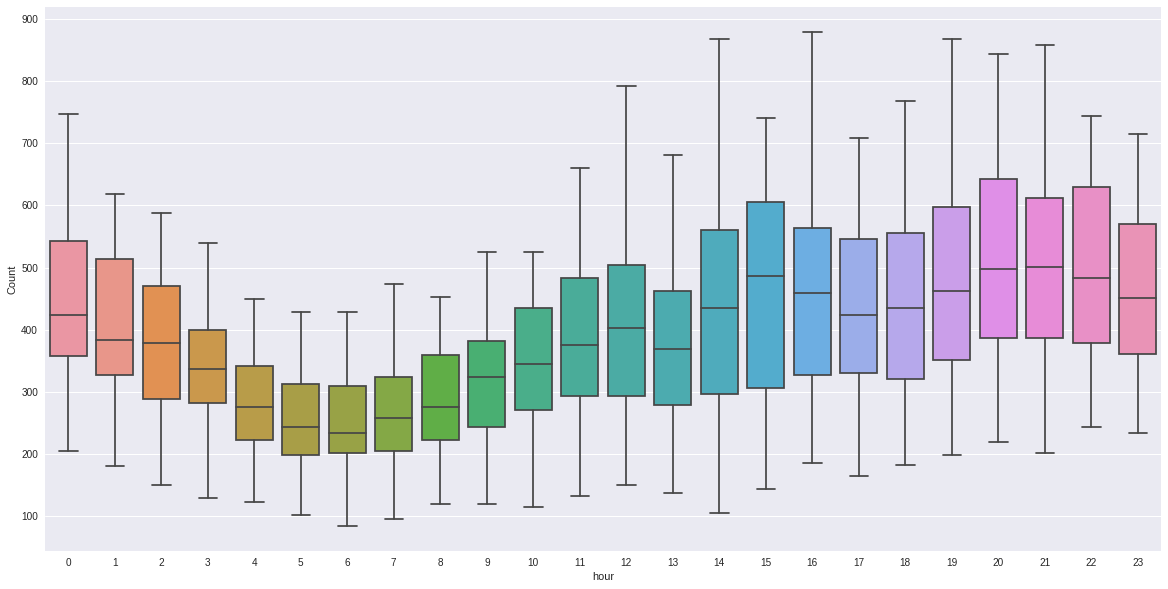

In [11]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="hour", y="Count", data=data)

### Here we can see the hour pattern in a day. From hour 0 to 6 the count decrease and from 6 to 12 it increase and than it decrease and increase.

### So these patterns are repeating for all the year but month by month the count is increase in each hour/day. 

In [12]:
y = data['Count']
data = data.drop(['Count'], axis=1)
sub_test = test.drop(['ID','Count'], axis=1)

# Implementing Xgboost regression model on the data

In [13]:
def evalerror(preds, dtrain):
    """
    calculate RMSE between data grond truth and predictions
    """
    labels = dtrain.get_label()
    return 'error', math.sqrt(mean_squared_error(labels, preds))

# split data to training and validation sets
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.10, random_state=2343)

# convert data to Dmatrix format for xgboost
d_train = xgb.DMatrix(X_train, label=y_train)
d_valid = xgb.DMatrix(X_test, label=y_test)
d_test = xgb.DMatrix(sub_test)

params = {  
    "n_estimators": 100,
    "max_depth": 3,
    "learning_rate": 0.01,
    "colsample_bytree": 1,
    "subsample": 1,
    "gamma": 0.1,
    'reg_alpha': 0,
    "min_child_weight": 2,
}

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

# Train xgboost regressor
reg = xgb.train(params, d_train, 3500, watchlist,  feval = evalerror, maximize=False, verbose_eval=10)
# Predict from xgboost regressor
count = reg.predict(d_test)

[0]	train-error:413.753	valid-error:422.266
[10]	train-error:375.852	valid-error:383.287
[20]	train-error:341.68	valid-error:347.946
[30]	train-error:310.88	valid-error:316.122
[40]	train-error:283.122	valid-error:287.574
[50]	train-error:258.116	valid-error:261.751
[60]	train-error:235.607	valid-error:238.622
[70]	train-error:215.38	valid-error:217.742
[80]	train-error:197.205	valid-error:199.023
[90]	train-error:180.911	valid-error:182.23
[100]	train-error:166.305	valid-error:167.163
[110]	train-error:153.286	valid-error:153.831
[120]	train-error:141.616	valid-error:141.999
[130]	train-error:131.195	valid-error:131.536
[140]	train-error:121.83	valid-error:122.092
[150]	train-error:113.433	valid-error:113.615
[160]	train-error:106.064	valid-error:106.131
[170]	train-error:99.4726	valid-error:99.5188
[180]	train-error:93.5737	valid-error:93.6098
[190]	train-error:88.4118	valid-error:88.4249
[200]	train-error:83.7237	valid-error:83.7293
[210]	train-error:79.5931	valid-error:79.6434
[220

[1780]	train-error:37.157	valid-error:39.7174
[1790]	train-error:37.1246	valid-error:39.7004
[1800]	train-error:37.0977	valid-error:39.6868
[1810]	train-error:37.0577	valid-error:39.6613
[1820]	train-error:37.0319	valid-error:39.6396
[1830]	train-error:36.9991	valid-error:39.6216
[1840]	train-error:36.9722	valid-error:39.609
[1850]	train-error:36.9434	valid-error:39.5921
[1860]	train-error:36.9129	valid-error:39.5678
[1870]	train-error:36.8851	valid-error:39.5485
[1880]	train-error:36.8615	valid-error:39.5302
[1890]	train-error:36.8388	valid-error:39.5207
[1900]	train-error:36.8093	valid-error:39.4997
[1910]	train-error:36.7822	valid-error:39.4894
[1920]	train-error:36.7654	valid-error:39.4815
[1930]	train-error:36.7391	valid-error:39.4669
[1940]	train-error:36.7181	valid-error:39.4582
[1950]	train-error:36.6964	valid-error:39.4417
[1960]	train-error:36.6743	valid-error:39.4276
[1970]	train-error:36.6572	valid-error:39.4164
[1980]	train-error:36.6376	valid-error:39.4099
[1990]	train-er

In [14]:
# save test submission
sample_submission = pd.DataFrame({
        "ID": ID,
        "Count": count
    })
sample_submission.to_csv('sample_submission5.csv', index=False)